# Análisis exploratorio de datos

Notebook para explorar el DataFrame de estadísticas de equipos.

## Importar Librerías

In [121]:
import pandas as pd
from pathlib import Path

## Cargar Datos

In [122]:
# Ruta donde están guardados los DataFrames
DATAFRAMES_FOLDER = Path("./ETL/dataframes")

# Cargar DataFrame de estadísticas de equipos
df_teams = pd.read_parquet(DATAFRAMES_FOLDER / "team_statistics.parquet")
df_players = pd.read_parquet(DATAFRAMES_FOLDER / "player_statistics.parquet")

## Explorar Datos de teams y sus estadisticas

In [123]:
# Ver información general del DataFrame
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_id                  1938 non-null   object 
 1   team_id                   1938 non-null   object 
 2   team_name                 1938 non-null   object 
 3   team_qualifier            1938 non-null   object 
 4   event_status              1938 non-null   object 
 5   match_status              1938 non-null   object 
 6   score                     1938 non-null   int64  
 7   ball_possession           1922 non-null   float64
 8   cards_given               1938 non-null   int64  
 9   chances_created           1174 non-null   float64
 10  clearances                1174 non-null   float64
 11  corner_kicks              1938 non-null   int64  
 12  crosses_successful        1174 non-null   float64
 13  crosses_total             1174 non-null   float64
 14  crosses_

### Quitamos del dataframe los eventos que han sucedido, es decir dejamos solo los que tienen status status="closed" y match_status="ended"

In [124]:
df_teams = df_teams[(df_teams['event_status'] == 'closed') & (df_teams['match_status'] == 'ended')] 
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_id                  1938 non-null   object 
 1   team_id                   1938 non-null   object 
 2   team_name                 1938 non-null   object 
 3   team_qualifier            1938 non-null   object 
 4   event_status              1938 non-null   object 
 5   match_status              1938 non-null   object 
 6   score                     1938 non-null   int64  
 7   ball_possession           1922 non-null   float64
 8   cards_given               1938 non-null   int64  
 9   chances_created           1174 non-null   float64
 10  clearances                1174 non-null   float64
 11  corner_kicks              1938 non-null   int64  
 12  crosses_successful        1174 non-null   float64
 13  crosses_total             1174 non-null   float64
 14  crosses_

### Se identifican algunas estadisticas que estan presentes solo en 1174 filas y no en el conjunto total de 1938. Vamos a explorar por que puede estar pasando esto. Identificamos las columnas que tienen valores nulos

In [125]:
df_teams.isnull().sum()


event_id                       0
team_id                        0
team_name                      0
team_qualifier                 0
event_status                   0
match_status                   0
score                          0
ball_possession               16
cards_given                    0
chances_created              764
clearances                   764
corner_kicks                   0
crosses_successful           764
crosses_total                764
crosses_unsuccessful         766
defensive_blocks             764
diving_saves                 764
dribbles_completed           764
fouls                          0
free_kicks                     0
goal_kicks                     0
injuries                       0
interceptions                764
long_passes_successful       764
long_passes_total            764
long_passes_unsuccessful     764
loss_of_possession           764
offsides                       0
passes_successful            764
passes_total                 764
passes_uns

In [126]:
#Se identifican 764 filas, que equivalen a 382 juegos donde no se tiene la informacion de algunas estadisticas. 
#esto puede deberse a que ciertos juegos son low coverage, es decir, no se tiene la informacion de todas las estadisticas.
#o que el API cambio de version en algun momento y empezo a incorporar nuevas estadisticas.
#Por lo tanto, se decide eliminar estas filas del dataframe.    
cols_with_764_nulls = [
    "chances_created",
    "clearances",
    "crosses_successful",
    "crosses_total",
    "defensive_blocks",
    "diving_saves",
    "dribbles_completed",
    "interceptions",
    "long_passes_successful",
    "long_passes_total",
    "long_passes_unsuccessful",
    "loss_of_possession",
    "passes_successful",
    "passes_total",
    "passes_unsuccessful",
    "tackles_successful",
    "tackles_total",
    "was_fouled"
]

### Si bien es cierto estas estadisticas no estan presentes como atributos del equipo, si estan presentes como atributos de los jugadores, por lo que si sumamos las estadisticas de los jugadores, obtendremos las estadisticas del equipo.

### En este caso tenemos que sumar las estadisticas de los jugadores de cada team, en un determinado partido, y asignar el valor correspondiente a la columna del equipo. Para ello, primero agrupamos el dataframe por partido y team, y luego sumamos las estadisticas de los jugadores. Se crea una copia del dataframe original para no perder la informacion original.

In [127]:
# 1. Crear una copia del dataframe original para no perder la información
df_teams_agg = df_teams.copy()

# 2. Agrupar las estadísticas de los jugadores por partido (event_id) y equipo (team_id)
# Sumamos las columnas identificadas con nulos (cols_with_764_nulls)
df_players_sum = df_players.groupby(['event_id', 'team_id'])[cols_with_764_nulls].sum().reset_index()

# 3. Asegurar que los tipos de datos de las llaves coincidan (convertir a string para evitar errores de cruce)
df_teams_agg[['event_id', 'team_id']] = df_teams_agg[['event_id', 'team_id']].astype(str)
df_players_sum[['event_id', 'team_id']] = df_players_sum[['event_id', 'team_id']].astype(str)

# 4. Asignar los valores correspondientes a las columnas del equipo
# Utilizamos 'update' seteando los índices para que los valores se alineen correctamente por partido y equipo
df_teams_agg.set_index(['event_id', 'team_id'], inplace=True)
df_players_sum.set_index(['event_id', 'team_id'], inplace=True)

# 'update' sobrescribe los valores existentes (o nulos) con los calculados de los jugadores
df_teams_agg.update(df_players_sum)

# 5. Restaurar el índice para que event_id y team_id vuelvan a ser columnas
df_teams_agg.reset_index(inplace=True)

# Reemplazar el df_teams original con la versión que ya no tiene nulos
df_teams = df_teams_agg.copy()

# Verificar que los nulos han sido completados
print("Nulos restantes en columnas agregadas:")
print(df_teams[cols_with_764_nulls].isnull().sum())

Nulos restantes en columnas agregadas:
chances_created             0
clearances                  0
crosses_successful          0
crosses_total               0
defensive_blocks            0
diving_saves                0
dribbles_completed          0
interceptions               0
long_passes_successful      0
long_passes_total           0
long_passes_unsuccessful    0
loss_of_possession          0
passes_successful           0
passes_total                0
passes_unsuccessful         0
tackles_successful          0
tackles_total               0
was_fouled                  0
dtype: int64


In [128]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_id                  1938 non-null   object 
 1   team_id                   1938 non-null   object 
 2   team_name                 1938 non-null   object 
 3   team_qualifier            1938 non-null   object 
 4   event_status              1938 non-null   object 
 5   match_status              1938 non-null   object 
 6   score                     1938 non-null   int64  
 7   ball_possession           1922 non-null   float64
 8   cards_given               1938 non-null   int64  
 9   chances_created           1938 non-null   float64
 10  clearances                1938 non-null   float64
 11  corner_kicks              1938 non-null   int64  
 12  crosses_successful        1938 non-null   float64
 13  crosses_total             1938 non-null   float64
 14  crosses_

### Aqui vemos como ya todas las estadisticas que necesitamos tienen los valores completos. 

### Notamos que hay en la estadistica ball_possession tenemos 14 valores null, es decir, 7 partidos en los que no se registro esta estadistica. 
### Esto se puede deber a que en esos partidos no se registro la estadistica o a que hubo un error en la recoleccion de los datos.
### Se decide rellenar esos valores con la media del ball possession de los partidos registrados. 

In [129]:
df_teams["ball_possession"] = df_teams.groupby("team_id")["ball_possession"].transform(lambda x: x.fillna(x.mean()))
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_id                  1938 non-null   object 
 1   team_id                   1938 non-null   object 
 2   team_name                 1938 non-null   object 
 3   team_qualifier            1938 non-null   object 
 4   event_status              1938 non-null   object 
 5   match_status              1938 non-null   object 
 6   score                     1938 non-null   int64  
 7   ball_possession           1938 non-null   float64
 8   cards_given               1938 non-null   int64  
 9   chances_created           1938 non-null   float64
 10  clearances                1938 non-null   float64
 11  corner_kicks              1938 non-null   int64  
 12  crosses_successful        1938 non-null   float64
 13  crosses_total             1938 non-null   float64
 14  crosses_

### Con esto logramos tener ya una data integra, sin valores nulos y lista para ser utilizada.
### Ahora vamos a dejar en el dataframe solamente los estadisticas relevantes para nuestro analisis.
### Y crear algunas mas derivadas de las estadisticas originales, lo que conocemos como Feature Engineering

In [130]:
# Limpiar DataFrame y seleccionar solo las columnas necesarias
# Primero crear la columna is_home basada en team_qualifier
df_teams['is_home'] = (df_teams['team_qualifier'] == 'home').astype(int)

# Lista de columnas a mantener
columns_to_keep = [
    "ball_possession",
    "chances_created",
    "clearances",
    "corner_kicks",
    "crosses_successful",
    "crosses_total",
    "defensive_blocks",
    "dribbles_completed",
    "fouls",
    "free_kicks",
    "goal_kicks",
    "interceptions",
    "long_passes_successful",
    "long_passes_total",
    "long_passes_unsuccessful",
    "loss_of_possession",
    "offsides",
    "passes_successful",
    "passes_total",
    "passes_unsuccessful",
    "shots_blocked",
    "shots_off_target",
    "shots_on_target",
    "shots_total",
    "tackles_successful",
    "tackles_total",
    "throw_ins",
    'event_id',
    'team_id',
    'team_name',
    'is_home',
    'score'
]

# Crear DataFrame limpio con solo las columnas necesarias
df_clean = df_teams[columns_to_keep].copy()

# Crear variables derivadas de itras estadisticas: Feature Engineering

# 1. Shot Accuracy (calidad del remate)
df_clean['shot_accuracy'] = df_clean['shots_on_target'] / df_clean['shots_total']

# 2. Shot Volume per Possession (verticalidad ofensiva)
df_clean['shot_volume_per_possession'] = df_clean['shots_total'] / df_clean['ball_possession']
df_clean["shot_accuracy"] = df_clean["shot_accuracy"].fillna(0)



df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ball_possession             1938 non-null   float64
 1   chances_created             1938 non-null   float64
 2   clearances                  1938 non-null   float64
 3   corner_kicks                1938 non-null   int64  
 4   crosses_successful          1938 non-null   float64
 5   crosses_total               1938 non-null   float64
 6   defensive_blocks            1938 non-null   float64
 7   dribbles_completed          1938 non-null   float64
 8   fouls                       1938 non-null   int64  
 9   free_kicks                  1938 non-null   int64  
 10  goal_kicks                  1938 non-null   int64  
 11  interceptions               1938 non-null   float64
 12  long_passes_successful      1938 non-null   float64
 13  long_passes_total           1938 

### Ahora que tenemos nuestro dataset limpio, vamos a guardarlo para posteriormente poder usarlo en el futuro.

In [131]:
# 1. Definir la ruta de salida
OUTPUT_FILE = DATAFRAMES_FOLDER / "team_statistics_clean.parquet"

# 2. Guardar el DataFrame como Parquet
df_clean.to_parquet(OUTPUT_FILE, index=False, engine='pyarrow')
print(f"✅ DataFrame guardado exitosamente en: {OUTPUT_FILE}")

# 3. Ejemplo de cómo volver a cargarlo para su uso posterior
# df_loaded = pd.read_parquet(OUTPUT_FILE)
# df_loaded.head()

✅ DataFrame guardado exitosamente en: ETL/dataframes/team_statistics_clean.parquet


In [132]:
file_path = Path("./ETL/dataframes/team_statistics_clean.parquet")
# Cargar el DataFrame
df_clean = pd.read_parquet(file_path)
# Verificar la carga
print(f"DataFrame cargado: {df_clean.shape}")
df_clean.head()

DataFrame cargado: (1938, 34)


,ball_possession,chances_created,clearances,corner_kicks,crosses_successful,crosses_total,defensive_blocks,dribbles_completed,fouls,free_kicks,...,tackles_successful,tackles_total,throw_ins,event_id,team_id,team_name,is_home,score,shot_accuracy,shot_volume_per_possession
0,45.0,7.0,28.0,3,1.0,12.0,3.0,2.0,10,18,...,5.0,5.0,25,sr:sport_event:50852687,sr:competitor:2859,Getafe CF,1,1,0.333333,0.200000
1,55.0,5.0,41.0,2,2.0,13.0,6.0,0.0,16,11,...,3.0,4.0,23,sr:sport_event:50852687,sr:competitor:6577,UD Las Palmas,0,3,0.500000,0.145455
2,56.0,9.0,34.0,4,3.0,11.0,21.0,30.0,8,10,...,44.0,75.0,14,sr:sport_event:41893117,sr:competitor:2836,Atletico Madrid,1,2,0.555556,0.160714
3,44.0,4.0,29.0,4,4.0,22.0,8.0,13.0,9,13,...,31.0,75.0,14,sr:sport_event:41893117,sr:competitor:2885,Deportivo Alaves,0,1,0.200000,0.113636
4,41.0,9.0,10.0,4,5.0,18.0,12.0,15.0,12,23,...,73.0,121.0,25,sr:sport_event:41892991,sr:competitor:33779,Granada CF,1,2,0.583333,0.292683


In [133]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ball_possession             1938 non-null   float64
 1   chances_created             1938 non-null   float64
 2   clearances                  1938 non-null   float64
 3   corner_kicks                1938 non-null   int64  
 4   crosses_successful          1938 non-null   float64
 5   crosses_total               1938 non-null   float64
 6   defensive_blocks            1938 non-null   float64
 7   dribbles_completed          1938 non-null   float64
 8   fouls                       1938 non-null   int64  
 9   free_kicks                  1938 non-null   int64  
 10  goal_kicks                  1938 non-null   int64  
 11  interceptions               1938 non-null   float64
 12  long_passes_successful      1938 non-null   float64
 13  long_passes_total           1938 

### Perfecto. Ahora que nuestro Dataframe esta completo, limpio y almacenado, vamos a realizar un analisis exploratorio de datos para entender mejor nuestro dataset.

/tmp/ipykernel_35257/1240820600.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([home, away], labels=["Home", "Away"], showmeans=True)


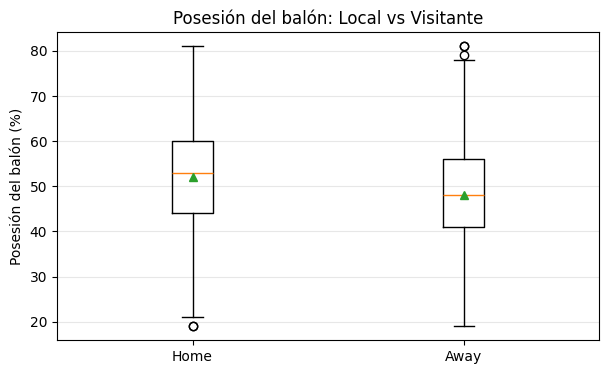

In [144]:
import matplotlib.pyplot as plt
import numpy as np

home = df_clean.loc[df_clean["is_home"] == 1, "ball_possession"].dropna()
away = df_clean.loc[df_clean["is_home"] == 0, "ball_possession"].dropna()

plt.figure(figsize=(7,4))
plt.boxplot([home, away], labels=["Home", "Away"], showmeans=True)
plt.ylabel("Posesión del balón (%)")
plt.title("Posesión del balón: Local vs Visitante")
plt.grid(axis="y", alpha=0.3)
plt.show()

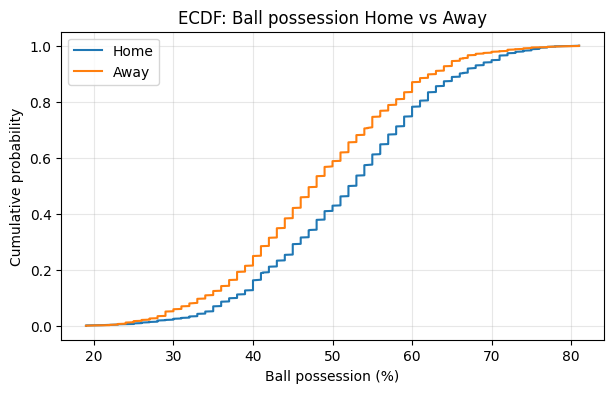

In [135]:
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

home = df_clean.loc[df_clean["is_home"] == 1, "ball_possession"].dropna().to_numpy()
away = df_clean.loc[df_clean["is_home"] == 0, "ball_possession"].dropna().to_numpy()

xh, yh = ecdf(home)
xa, ya = ecdf(away)

plt.figure(figsize=(7,4))
plt.plot(xh, yh, label="Home")
plt.plot(xa, ya, label="Away")
plt.xlabel("Ball possession (%)")
plt.ylabel("Cumulative probability")
plt.title("ECDF: Ball possession Home vs Away")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [136]:
df_clean[df_clean["is_home"] == 1]["score"].describe()

count    969.000000
mean       1.477812
std        1.258760
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: score, dtype: float64

In [137]:
df_clean[df_clean["is_home"] == 0]["score"].describe()

count    969.000000
mean       1.151703
std        1.080777
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: score, dtype: float64

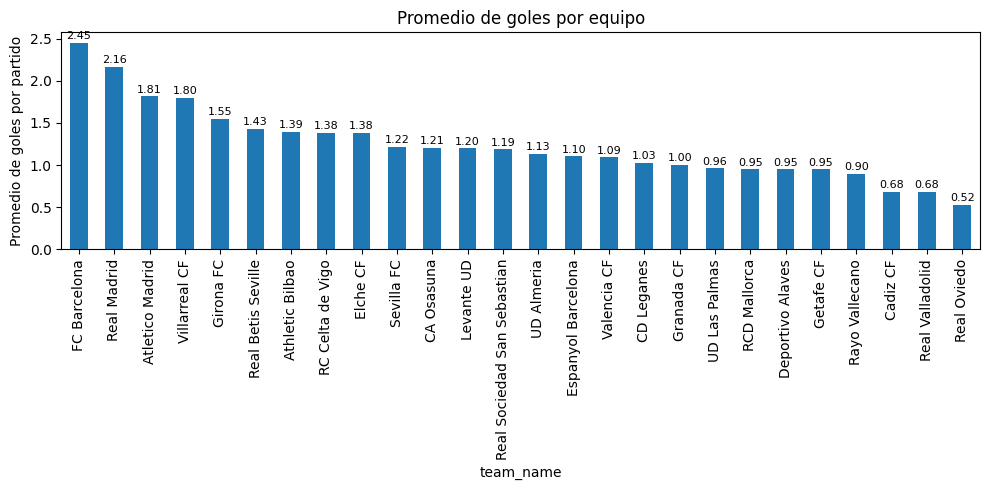

In [138]:
team_goals = (
    df_clean
    .groupby("team_name")["score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
ax = team_goals.plot(kind="bar")

plt.ylabel("Promedio de goles por partido")
plt.title("Promedio de goles por equipo")
plt.xticks(rotation=90)

# 👉 agregar valores arriba de cada barra
for i, v in enumerate(team_goals.values):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

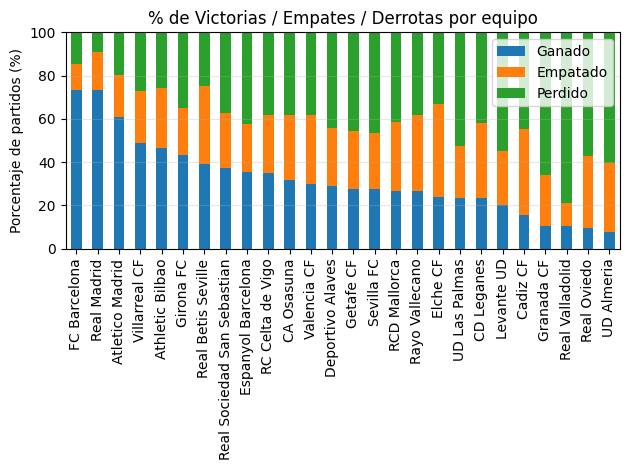

In [139]:
# =========================
# OBJETIVO
# =========================
# Queremos calcular, por equipo, el % de partidos:
# - Ganados
# - Empatados
# - Perdidos
#
# Importante: df_clean está a nivel "equipo-partido",
# es decir: cada event_id aparece 2 veces (home y away).

# Copia para no modificar el dataframe original
df_scores = df_clean.copy()

# =========================
# 1) CALCULAR GOLES DEL RIVAL (opp_score)
# =========================
# Para cada partido (event_id), invertimos el orden de los 2 scores.
# Así, la fila del equipo A obtiene el score del equipo B como opp_score.
df_scores["opp_score"] = (
    df_scores.groupby("event_id")["score"]
      .transform(lambda x: x.iloc[::-1].values)
)

# =========================
# 2) DEFINIR RESULTADO (Ganado / Empatado / Perdido) POR FILA
# =========================
df_scores["result"] = np.where(
    df_scores["score"] > df_scores["opp_score"], "Ganado",
    np.where(df_scores["score"] < df_scores["opp_score"], "Perdido", "Empatado")
)

# =========================
# 3) CALCULAR PORCENTAJES POR EQUIPO
# =========================
result_pct = (
    df_scores.groupby(["team_name", "result"])
      .size()
      .groupby(level=0)
      .apply(lambda x: 100 * x / x.sum())
      .unstack(fill_value=0)
)

# Asegurarnos de que existan todas las columnas aunque algún equipo no tenga una categoría
for col in ["Ganado", "Empatado", "Perdido"]:
    if col not in result_pct.columns:
        result_pct[col] = 0.0

# Ordenar columnas siempre igual
result_pct = result_pct[["Ganado", "Empatado", "Perdido"]]

# Ordenar equipos por % de victorias (para ver arriba los más fuertes)
result_pct = result_pct.sort_values("Ganado", ascending=False)

# =========================
# FIX: arreglar labels repetidos tipo "(Equipo, Equipo)"
# =========================
def limpiar_label(x):
    # Si el índice viene como tupla (ej: (FC Barcelona, FC Barcelona)),
    # nos quedamos con el primer elemento
    if isinstance(x, tuple) and len(x) > 0:
        return str(x[0])
    return str(x)

result_pct.index = result_pct.index.map(limpiar_label)

# Consolidar por nombre (por si había tuplas o duplicados)
result_pct = result_pct.groupby(result_pct.index).mean()

# Ordenar por % de Ganado (más a la izquierda)
result_pct = result_pct.sort_values("Ganado", ascending=False)

# Graficar
plt.figure(figsize=(12, 5))
ax = result_pct.plot(kind="bar", stacked=True)

plt.ylabel("Porcentaje de partidos (%)")
plt.title("% de Victorias / Empates / Derrotas por equipo")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

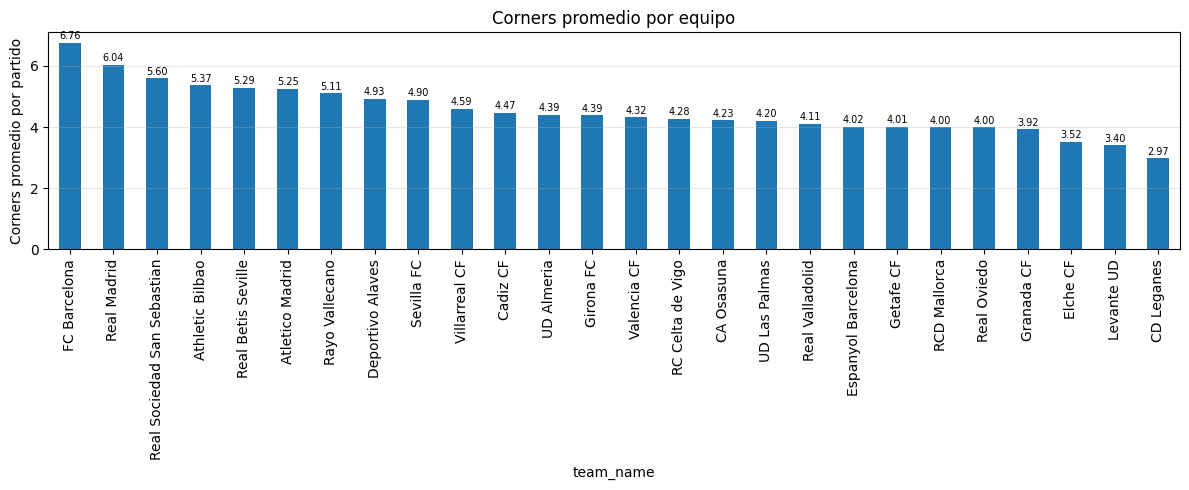

In [140]:

team_corners = (
    df_clean
    .groupby("team_name")["corner_kicks"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,5))
ax = team_corners.plot(kind="bar")

plt.ylabel("Corners promedio por partido")
plt.title("Corners promedio por equipo")
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)

for i, v in enumerate(team_corners.values):
    ax.text(i, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()

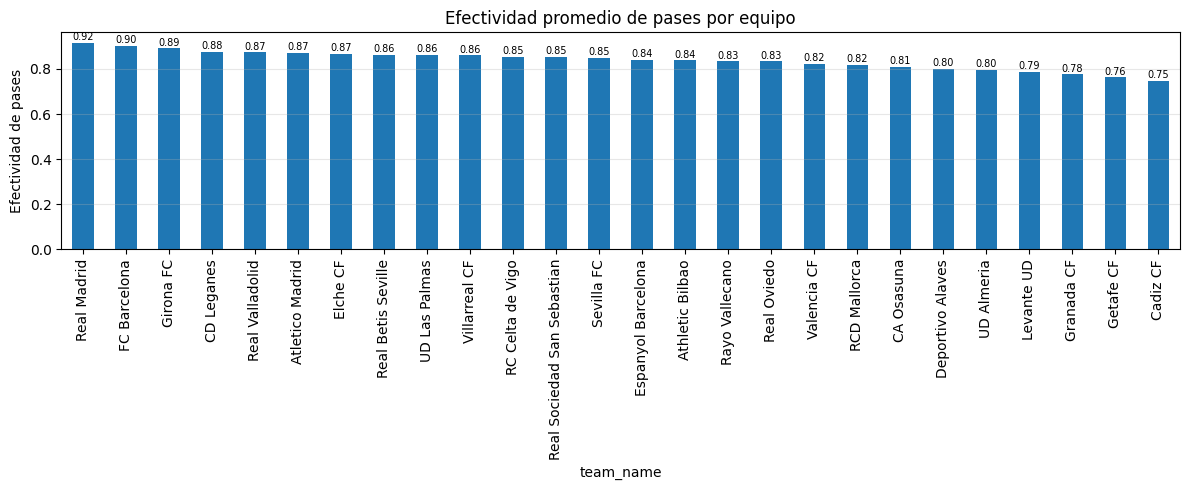

In [141]:
# Efectividad de pases por fila (equipo–partido)
df_clean["pass_accuracy"] = (
    df_clean["passes_successful"] / df_clean["passes_total"]
)

# Promedio de efectividad por equipo
team_pass_accuracy = (
    df_clean
    .groupby("team_name")["pass_accuracy"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,5))
ax = team_pass_accuracy.plot(kind="bar")

plt.ylabel("Efectividad de pases")
plt.title("Efectividad promedio de pases por equipo")
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)

for i, v in enumerate(team_pass_accuracy.values):
    ax.text(i, v + 0.003, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()

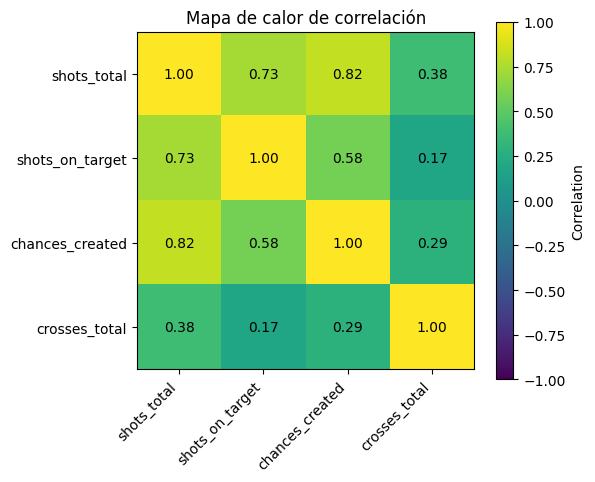

In [142]:
vars_ = ["shots_total", "shots_on_target", "chances_created", "crosses_total"]

corr = df_clean[vars_].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(vars_)), vars_, rotation=45, ha="right")
plt.yticks(range(len(vars_)), vars_)

for i in range(len(vars_)):
    for j in range(len(vars_)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

plt.title("Mapa de calor de correlación")
plt.tight_layout()
plt.show()

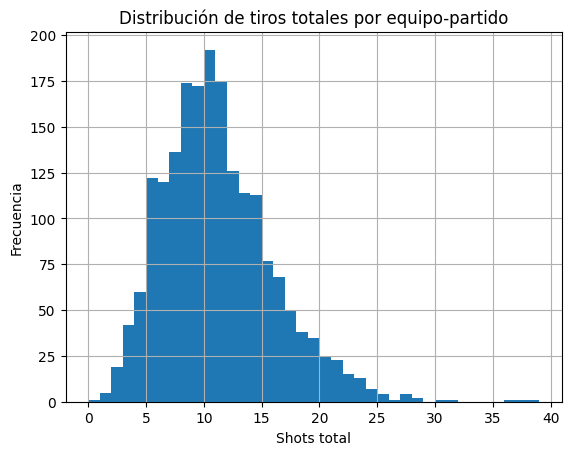

In [143]:
df_clean["shots_total"].hist(bins="auto")
plt.title("Distribución de tiros totales por equipo-partido")
plt.xlabel("Shots total")
plt.ylabel("Frecuencia")
plt.show()